**할일**

0. Label Encoder 사용 -> 다시 Reverse도 가능해야 함
1. train전처리기에는 crop을 넣지만 test전처리기에는 crop하지 않음
2. crop할 때, crop하고 resize? 이건 다시 생각해야됨

- train crop으로 224맞춰주고
- test crop안하고 224맞춰주기

# 그림으로 작가를 맞춰보자!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.models as models

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from torch.utils.data import Subset
from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import glob

import os
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

/Users/younkwon/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/younkwon/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/younkwon/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <AE6DCE26-A528-35ED-BB3D-88890D27E6B9> /Users/younkwon/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda')
device

device(type='mps')

# 0. 데이터 살펴보기

In [3]:
train_labels = pd.read_csv('./train.csv', index_col=1)
test_labels = pd.read_csv('./test.csv', index_col=1)
artists = pd.read_csv('./artists_info.csv')

display(train_labels.head(3))
display(test_labels.head(3))
display(artists.head(3))

,id,artist
img_path,,
./train/0000.jpg,0,Diego Velazquez
./train/0001.jpg,1,Vincent van Gogh
./train/0002.jpg,2,Claude Monet


,id
img_path,
./test/TEST_00000.jpg,TEST_00000
./test/TEST_00001.jpg,TEST_00001
./test/TEST_00002.jpg,TEST_00002


,name,years,genre,nationality
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian
2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican


### 레이블

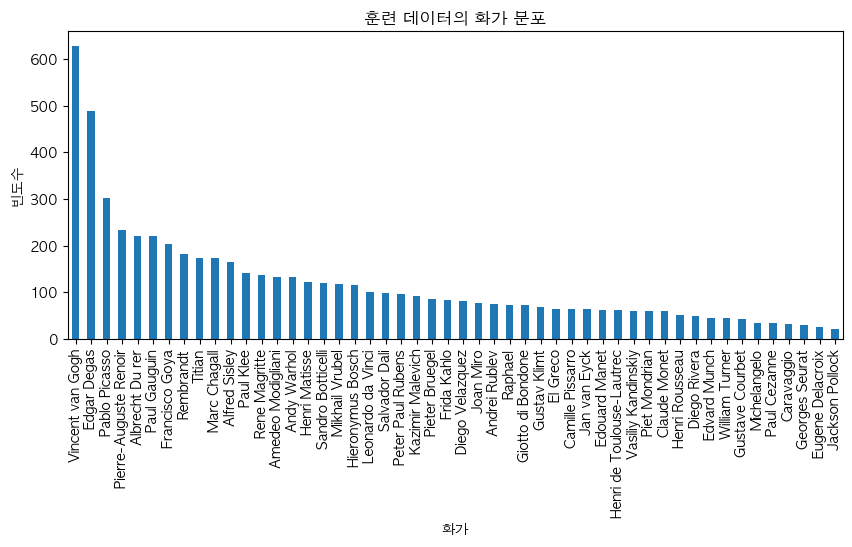

In [4]:
plt.figure(figsize=(10, 4))
train_labels['artist'].value_counts().plot.bar()
plt.title('훈련 데이터의 화가 분포')
plt.xlabel('화가')
plt.ylabel('빈도수')
plt.show()

In [5]:
top5_artists = list(train_labels['artist'].value_counts()[:5].index)

print('Number of images :', train_labels.shape[0])
print('Most Top5 Painters : ', top5_artists)

Number of images : 5911
Most Top5 Painters :  ['Vincent van Gogh', 'Edgar Degas', 'Pablo Picasso', 'Pierre-Auguste Renoir', 'Albrecht Du rer']


### 이미지

In [6]:
train_labels.index[0]

'./train/0000.jpg'

./train/5692.jpg


Text(0.5, 1.0, 'Edouard Manet')

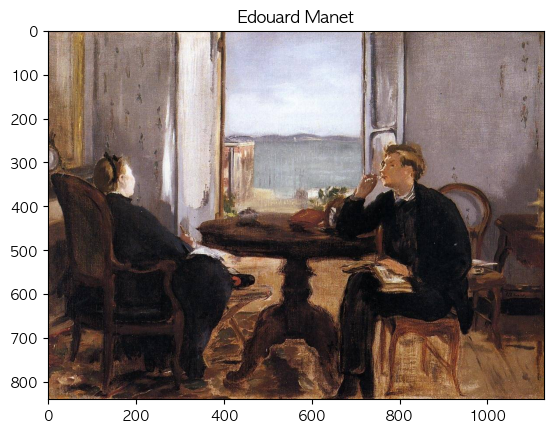

In [7]:
# 무작위 이미지 살펴보기

n = np.random.randint(0, train_labels.shape[0]-1)
image_name = train_labels.index[n]

image = mpimg.imread(image_name)
print(image_name)
plt.imshow(image)
plt.title(train_labels.iloc[n, 1])

- 데이터 불러오는 class 만들기

# 1. 데이터 불러오기

- 다시 되돌려놓는 코드
```
# 'fruit_encoded' 열의 값에서 Label Encoding 전후의 값을 변환하여 'fruit_decoded' 열을 생성
df['fruit_decoded'] = df['fruit_encoded'].map({v: k for k, v in label_map.items()})
```

In [8]:
train_labels['LE_artist'] = train_labels['artist'].astype('category').cat.codes
train_labels.head(3)

,id,artist,LE_artist
img_path,,,
./train/0000.jpg,0,Diego Velazquez,9
./train/0001.jpg,1,Vincent van Gogh,48
./train/0002.jpg,2,Claude Monet,7


In [9]:
# LabelEncoding 전 후의 맵을 딕셔너리 형태로 생성
label_map = dict(enumerate(train_labels['artist'].astype('category').cat.categories))

In [10]:
for key, value in label_map.items():
    print(key, value, end='/')

0 Albrecht Du rer/1 Alfred Sisley/2 Amedeo Modigliani/3 Andrei Rublev/4 Andy Warhol/5 Camille Pissarro/6 Caravaggio/7 Claude Monet/8 Diego Rivera/9 Diego Velazquez/10 Edgar Degas/11 Edouard Manet/12 Edvard Munch/13 El Greco/14 Eugene Delacroix/15 Francisco Goya/16 Frida Kahlo/17 Georges Seurat/18 Giotto di Bondone/19 Gustav Klimt/20 Gustave Courbet/21 Henri Matisse/22 Henri Rousseau/23 Henri de Toulouse-Lautrec/24 Hieronymus Bosch/25 Jackson Pollock/26 Jan van Eyck/27 Joan Miro/28 Kazimir Malevich/29 Leonardo da Vinci/30 Marc Chagall/31 Michelangelo/32 Mikhail Vrubel/33 Pablo Picasso/34 Paul Cezanne/35 Paul Gauguin/36 Paul Klee/37 Peter Paul Rubens/38 Pierre-Auguste Renoir/39 Piet Mondrian/40 Pieter Bruegel/41 Raphael/42 Rembrandt/43 Rene Magritte/44 Salvador Dali/45 Sandro Botticelli/46 Titian/47 Vasiliy Kandinskiy/48 Vincent van Gogh/49 William Turner/

In [11]:
display(train_labels.head(3))
display(test_labels.head(3))

,id,artist,LE_artist
img_path,,,
./train/0000.jpg,0,Diego Velazquez,9
./train/0001.jpg,1,Vincent van Gogh,48
./train/0002.jpg,2,Claude Monet,7


,id
img_path,
./test/TEST_00000.jpg,TEST_00000
./test/TEST_00001.jpg,TEST_00001
./test/TEST_00002.jpg,TEST_00002


In [12]:
class PaintingsDataset():
    def __init__(self, root_dir, labels_df=None,  transform=None):
        self.filepaths = sorted(glob.glob(root_dir + '*.jpg'))
        self.transform = transform
        if labels_df is not None: # train일때
            self.labels_df = labels_df
            
        else: self.labels_df = None # test일때
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        # (1) 이미지 준비
        image_filepath = self.filepaths[idx]

        image = cv2.imread(image_filepath) # np.array형태(BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # np.array형태(RGB)로 반환
                
        # (2) Label 준비
        if self.labels_df is not None: # train일때
            file_name = image_filepath
            painter = self.labels_df.loc['./'+file_name]['LE_artist']
        
        # (3) 반환할 이미지와 Label 만들기
        
        # 딕셔너리화
        if self.labels_df is not None: # csv가 들어왔을때 (train)
            imagelabel_dict1 = self.transform(image=image)
            imagelabel_dict1['label'] = painter
            return imagelabel_dict1
        
        else: # csv가 들어오지 않았을때 (test)
            imagelabel_dict2 = self.transform(image=image)
            return imagelabel_dict2
        

In [13]:
train_transform = A.Compose([
    A.Resize(800, 800),
    A.RandomCrop(224, 224),  # 약 4분의 1로 crop
    A.HorizontalFlip(p=0.5), # 0.5확률로 좌우반전
    A.CoarseDropout(max_holes=2, max_height=64, max_width=64, p=0.5), # 0.5확률로 2개의 Box 만들기
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                max_pixel_value=255.0,
                always_apply=False,
                p=1.0), # 정규화
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                max_pixel_value=255.0,
                always_apply=False,
                p=1.0),
    ToTensorV2()
])

In [14]:
# train_image와 train_label을 담고 있는 Dict
trainset = PaintingsDataset(root_dir='train/', labels_df=train_labels, transform=train_transform)

# test_image만을 담고 있는 Dict
testset = PaintingsDataset(root_dir='test/', labels_df=None, transform=test_transform)

In [15]:
print(type(trainset), len(trainset))
print(type(testset), len(testset))

<class '__main__.PaintingsDataset'> 5911
<class '__main__.PaintingsDataset'> 12670


In [16]:
#plt.imshow(trainset[0]['image'].permute(1, 2, 0))

# 2. 데이터 나누기

- Train과 Valid를 나누기 위해 Split

In [17]:
train_indices, valid_indices = train_test_split(range(len(trainset)),
                                                test_size=0.2,
                                                random_state=42)

print('Train 데이터셋의 샘플수 :', len(train_indices))
print('Valid 데이터셋의 샘플수 :', len(valid_indices))

Train 데이터셋의 샘플수 : 4728
Valid 데이터셋의 샘플수 : 1183


- train_set과 valid_set 만들기

In [18]:
train_set = Subset(trainset, train_indices)
valid_set = Subset(trainset, valid_indices)

In [19]:
print(type(train_set), len(train_set))
print(type(valid_set), len(valid_set))

<class 'torch.utils.data.dataset.Subset'> 4728
<class 'torch.utils.data.dataset.Subset'> 1183


- 만들어진 set 확인

In [20]:
print('train_set의 0번째 이미지와 레이블')
print('이미지의 shape :', train_set[0]['image'].shape)
print('레이블 :', train_set[0]['label'], label_map[train_set[0]['label']])

train_set의 0번째 이미지와 레이블
이미지의 shape : torch.Size([3, 224, 224])
레이블 : 20 Gustave Courbet


# 3. 데이터 시각화

In [21]:
filepaths = sorted(glob.glob('./train/*.jpg'))
filepaths[:3]

['./train/0000.jpg', './train/0001.jpg', './train/0002.jpg']

## 3. 1 전처리기 적용 전

In [22]:
train_labels.iloc[10, 1]

'Caravaggio'

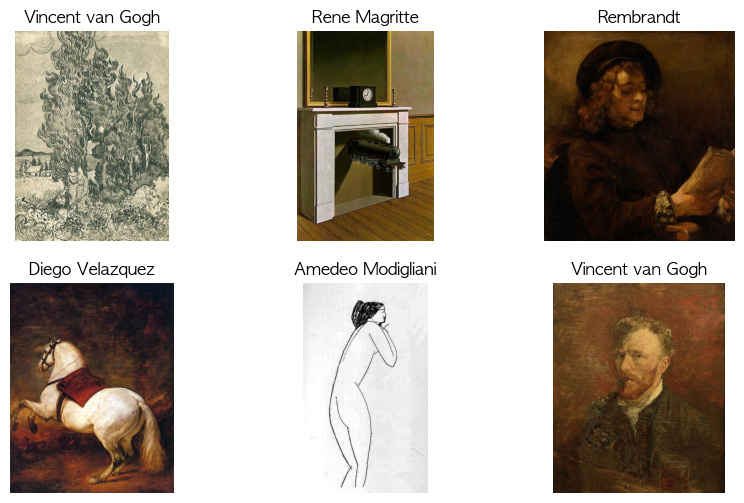

In [23]:
idxs = np.random.randint(0, len(filepaths)-1, 6)

figure, axes = plt.subplots(2, 3, figsize=(10, 6), )
axes = axes.flatten()

for i, idx in enumerate(idxs):
    image = mpimg.imread(filepaths[idx])
    axes[i].imshow(image)
    axes[i].set_title(train_labels.iloc[idx, 1])
    axes[i].axis('off')

## 3. 2 전처리기 적용 후

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


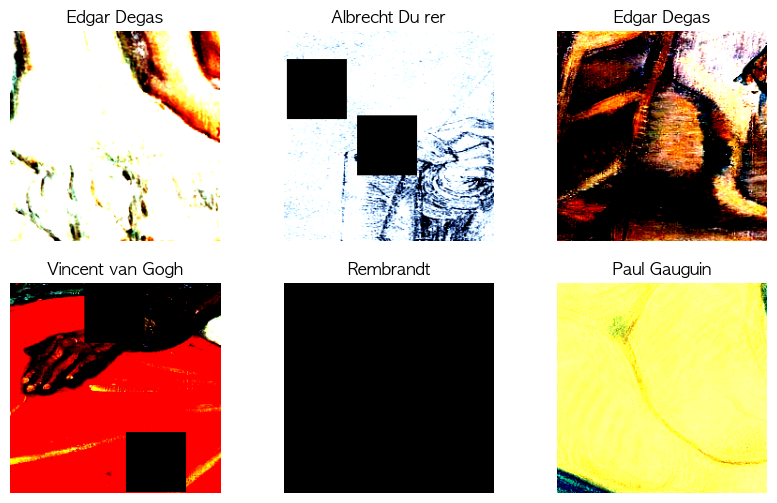

In [24]:
idxs = np.random.randint(0, len(filepaths)-1, 6)

figure, axes = plt.subplots(2, 3, figsize=(10, 6), )
axes = axes.flatten()

for i, idx in enumerate(idxs):
    image = trainset[idx]['image'].permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title(train_labels.iloc[idx, 1])
    axes[i].axis('off')

# 4. 데이터 적재 (batch가 반복되는 loader형식으로)

In [23]:
batch_size = 16 # Batch Size(한 덩어리에 몇개의 샘플이 들어가있는지)

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # 4728개
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False) # 1183개

In [24]:
print('trainset의 배치 수 :', len(train_set)/batch_size) # 약 300개의 미니배치
print('validset의 배치 수 :', len(valid_set)/batch_size)

trainset의 배치 수 : 295.5
validset의 배치 수 : 73.9375


In [25]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'], batch['label']
images, labels = batch['image'], batch['label']

print('한 Batch에 대하여 :', images.shape, labels.shape)

한 Batch에 대하여 : torch.Size([16, 3, 224, 224]) torch.Size([16])


# 5. 모델 생성

**구현해볼 모델**
1. AlexNet
2. VGG
3. GoogLeNet
4. ResNet # 그래프

- 전이학습은 가능한 사용하지 않기 -> 모델을 직접 만들어보는 것이 더 의미있을 것
- 제출때는 전이학습으로 좋은 모델 가져와서 하고, 과정은 직접 해보기

## 5. 1 AlexNet

**Block별 OUTPUT 확인하기**

In [26]:
# AlexNet의 기본 틀

class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential()
        self.conv_block2 = nn.Sequential()
        self.conv_block3 = nn.Sequential()
        self.conv_block4 = nn.Sequential()
        self.conv_block5 = nn.Sequential()
        
        self.linear1 = nn.Linear()
        self.batch_norm = nn.BatchNorm2d()
        self.linear2 = nn.Linear(out_features=55)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x

## 5. 2 VGG16

In [27]:
# VGG16의 기본 틀

class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential()
        self.conv_block2 = nn.Sequential()
        self.conv_block3 = nn.Sequential()
        self.conv_block4 = nn.Sequential()
        self.conv_block5 = nn.Sequential()
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # 1*1사이즈로 축소
        self.classifier = nn.Sequential()
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        x = self.avg_pool(x)
        
        x = self.classifier(x)
        
        return x

## 5. 3 GoogLeNet

## 5. 4 ResNet

# 6. 모델 컴파일

## 6. 1 학습률 정의

## 6. 2 옵티마이저

## 6. 3 학습률 조절 스케쥴

- optimizer (필수): 학습률을 조정할 옵티마이저입니다.
- mode (선택적, 기본값: 'min'): 모니터링 중인 지표에서 개선을 확인하기 위한 방법입니다. 'min', 'max', 'abs' 중 하나를 선택할 수 있습니다. 예를 들어, 손실 함수를 모니터링하는 경우, 'min' 모드를 선택하면 손실이 줄어들 때마다 학습률이 감소합니다.
- factor (선택적, 기본값: 0.1): 새로운 학습률을 계산할 때 현재 학습률에 곱해지는 인자입니다. 예를 들어, factor=0.5로 설정하면 학습률이 1/2로 줄어듭니다.
- patience (선택적, 기본값: 10): 학습률이 개선되지 않은 에포크 수입니다. 예를 들어, patience=5로 설정하면 5에포크 동안 개선이 없으면 학습률을 조정합니다.
- threshold (선택적, 기본값: 1e-4): 개선된 것으로 간주되는 최소한의 변화입니다. 예를 들어, threshold=1e-2로 설정하면 학습률이 1e-2보다 적게 개선되면 개선이 없는 것으로 간주합니다.
- threshold_mode (선택적, 기본값: 'rel'): threshold를 해석하는 방법입니다. 'rel'이면 변화는 현재 학습률에 대한 비율로 해석됩니다. 'abs'이면 변화는 절대적인 값으로 해석됩니다.
- cooldown (선택적, 기본값: 0): 개선이 없어 학습률을 감소시킨 후 다시 학습률을 감소시키지 않는 대기 기간입니다. 예를 들어, cooldown=5로 설정하면 학습률이 감소된 후 5에포크 동안은 다시 학습률을 감소시키지 않습니다.
- min_lr (선택적, 기본값: 0): 학습률의 하한입니다. 학습률이 이 값보다 작아지면 더 이상 학습률을 줄이지 않습니다.
- verbose (선택적, 기본값: False): True로 설정하면 학습률이 조정될 때마다 로그가 출력됩니다.

## 6. 4 Model Summary

# 7. 모델 훈련